## Loading the 20 newsgroups dataset

In [1]:
from collections import Counter
import scipy
import numpy as np

In [2]:
categories = ['alt.atheism', 'soc.religion.christian', 
              'comp.graphics', 'sci.med']

In [3]:
from sklearn.datasets import fetch_20newsgroups
twenty_train = fetch_20newsgroups(subset='train',
                                  categories=categories,
                                  shuffle=True,
                                  random_state=42)

len(twenty_train.data)

2257

In [4]:
type(twenty_train)

sklearn.datasets.base.Bunch

In [5]:
twenty_train.target_names

['alt.atheism', 'comp.graphics', 'sci.med', 'soc.religion.christian']

In [6]:
file_ind = 0
print(twenty_train.filenames[file_ind],
      "\n*****\n",
      twenty_train.target_names[twenty_train.target[file_ind]],
      "\n*****\n",
      twenty_train.data[file_ind])

/Users/wah/scikit_learn_data/20news_home/20news-bydate-train/comp.graphics/38440 
*****
 comp.graphics 
*****
 From: sd345@city.ac.uk (Michael Collier)
Subject: Converting images to HP LaserJet III?
Nntp-Posting-Host: hampton
Organization: The City University
Lines: 14

Does anyone know of a good way (standard PC application/PD utility) to
convert tif/img/tga files into LaserJet III format.  We would also like to
do the same, converting to HPGL (HP plotter) files.

Please email any response.

Is this the correct group?

Thanks in advance.  Michael.
-- 
Michael Collier (Programmer)                 The Computer Unit,
Email: M.P.Collier@uk.ac.city                The City University,
Tel: 071 477-8000 x3769                      London,
Fax: 071 477-8565                            EC1V 0HB.



In [7]:
target_counts = Counter(twenty_train.target)
for k, v in list(target_counts.items()):
    target_counts[twenty_train.target_names[k]] = v
    del target_counts[k]
target_counts

Counter({'alt.atheism': 480,
         'comp.graphics': 584,
         'sci.med': 594,
         'soc.religion.christian': 599})

In [8]:
atheist_docs = np.array(twenty_train.data)[twenty_train.target == 0]

## Extracting features from text files

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(twenty_train.data)
X_train_counts.shape

(2257, 35788)

In [10]:
type(X_train_counts)

scipy.sparse.csr.csr_matrix

In [11]:
vocab = set(count_vect.vocabulary_.keys())
len(vocab)

35788

### Stopwords
By default, `CountVectorizer` includes all stopwords

In [12]:
from sklearn.feature_extraction import stop_words
stops = stop_words.ENGLISH_STOP_WORDS

In [13]:
len(vocab & stops)

305

Passing `'english'` or a list of words to the `stop_words` parameter changes this.  

In [14]:
count_vect_with_stopwords = CountVectorizer(stop_words='english')
X_train_counts_stopped = count_vect_with_stopwords.fit_transform(twenty_train.data)
X_train_counts_stopped.shape

(2257, 35483)

In [15]:
vocab_stop = set(count_vect_with_stopwords.vocabulary_.keys())
len(vocab_stop & stops)

0

Another option is automatically detecting corpus-specific stopwords by filtering on the TF-IDF score.  Reducing the `max_df` parameter filters out words that are very common across documents, and the `min_df` parameter can be used to avoid overfitting (by ignoring words that appear in very few documents).  Note that both parameters can take a `float` in the range `[0.0, 1.0]` OR an `int`.

In [16]:
count_vect_tfidf = CountVectorizer(max_df=0.8, 
                                   min_df=2)
X_train_counts_tfidf = count_vect_tfidf.fit_transform(twenty_train.data)
X_train_counts_tfidf.shape

(2257, 18484)

In [17]:
count_vect.vocabulary_['horse']

16865

In [18]:
horses = scipy.sparse.find(X_train_counts[:, 16865])

In [19]:
horses[0]

array([ 218,  826, 1762, 1779, 1789, 1833, 1986, 2129], dtype=int32)

In [20]:
doc_matrix = np.array(twenty_train.data)
print(*doc_matrix[horses[0]])

From: eb3@world.std.com (Edwin Barkdoll)
Subject: Re: Blindsight
Organization: The World Public Access UNIX, Brookline, MA
Lines: 64

In article <19382@pitt.UUCP> geb@cs.pitt.edu (Gordon Banks) writes:
>In article <werner-240393161954@tol7mac15.soe.berkeley.edu> werner@soe.berkeley.edu (John Werner) writes:
>>In article <19213@pitt.UUCP>, geb@cs.pitt.edu (Gordon Banks) wrote:
>>> 
>>> Explain.  I thought there were 3 types of cones, equivalent to RGB.
>>
>>You're basically right, but I think there are just 2 types.  One is
>>sensitive to red and green, and the other is sensitive to blue and yellow. 
>>This is why the two most common kinds of color-blindness are red-green and
>>blue-yellow.
>>
>
>Yes, I remember that now.  Well, in that case, the cones are indeed
>color sensitive, contrary to what the original respondent had claimed.


	I'm not sure who the "original respondent" was but to
reiterate cones respond to particular portions of the spectrum, just
as _rods_ respond to certain 

### Using TF-IDF instead of counts

TF-IDF can help address two problems: one, it normalises over varying document lengths (so that a long document that mentions something in passing is not considered equivalent to a very short, focussed doument); and two, it down-weights words that appear in a large number of documents.  

In [21]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts_tfidf)
X_train_tfidf.shape

(2257, 18484)

The two steps, `fit` and `transform`, can be separated out.  I suppose this is useful if you want to use a vocabulary from a larger corpus when training on a smaller one.  

Another class, `TfidfVectorizer`, combines the `countVectorizer` with `TfidfTransformation` into a single step.

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_df = 0.8,
                                   min_df = 2)
X_train_tfidf = tfidf_vectorizer.fit_transform(twenty_train.data)
X_train_tfidf.shape

(2257, 18484)

## Training a classifier

The variant of naive Bayes most suitable for word counts is `MultiNomialNB`.

In [23]:
from sklearn.naive_bayes import MultinomialNB

clf_count = MultinomialNB().fit(X_train_counts, twenty_train.target)

To classify a new document we have to transform it in the same way as the training set, but without fitting. 

In [24]:
new_docs = ['God is love',
            'OpenGL on the GOU is fast',
            'Education and faith are not compatible']

In [25]:
X_new_counts = count_vect.transform(new_docs)
pred_count = clf_count.predict(X_new_counts)

for doc, cat in zip(new_docs, pred_count):
    print("'{}' => {}".format(doc, twenty_train.target_names[cat]))

'God is love' => soc.religion.christian
'OpenGL on the GOU is fast' => comp.graphics
'Education and faith are not compatible' => soc.religion.christian


Christianity and atheism are hard to tell apart...this is either ironic, or a shortcoming of our algorithm.

Trying the same process with the TF-IDF features:

In [26]:
clf_tfidf = MultinomialNB().fit(X_train_tfidf, twenty_train.target)
X_new_tfidf = tfidf_vectorizer.transform(new_docs)
pred_tfidf = clf_tfidf.predict(X_new_tfidf)

for doc, cat in zip(new_docs, pred_count):
    print("'{}' => {}".format(doc, twenty_train.target_names[cat]))

'God is love' => soc.religion.christian
'OpenGL on the GOU is fast' => comp.graphics
'Education and faith are not compatible' => soc.religion.christian


### Building a pipeline

The pipeline object makes it more conveient to train the model.

In [27]:
from sklearn.pipeline import Pipeline

count_pipeline = Pipeline([('vect', CountVectorizer()),
                           ('clf', MultinomialNB())])
tfidf_pipeline = Pipeline([('vect', TfidfVectorizer()),
                           ('clf', MultinomialNB())])

nb_count = count_pipeline.fit(twenty_train.data, twenty_train.target)
nb_tfidf = tfidf_pipeline.fit(twenty_train.data, twenty_train.target)

## Evaluation of the performance on the test set

In [28]:
twenty_test = fetch_20newsgroups(subset='test',
                                 categories=categories,
                                 shuffle=True,
                                 random_state=42)
len(twenty_test.data)

1502

In [32]:
count_pred = nb_count.predict(twenty_test.data)
count_acc = np.mean(count_pred == twenty_test.target)
count_acc

0.93408788282290278

In [33]:
tfidf_pred = nb_tfidf.predict(twenty_test.data)
tfidf_acc = np.mean(tfidf_pred == twenty_test.target)
tfidf_acc

0.83488681757656458

Interesting...classifying on the TF-IDF scores as demonstrated in the docs performs significantly worse than using the counts.

The docs also suggest trying a support vector machine (SGD = stochastic gradient descent).  Let's try two: one that uses count-based features and one that uses TF-IDF features. I'll use the parameters suggested on the docs page, even though I don't know what they all mean.  

In [34]:
from sklearn.linear_model import SGDClassifier

sgd_count = Pipeline([
        ('vect', CountVectorizer()),
        ('clf', SGDClassifier(loss='hinge',
                             penalty='l2',
                             alpha=1e-3,
                             n_iter=5,
                             random_state=42))
    ]).fit(twenty_train.data, twenty_train.target)
sgd_count_pred = sgd_count.predict(twenty_test.data)
sgd_count_acc = np.mean(sgd_count_pred == twenty_test.target)
sgd_count_acc

0.83555259653794944

In [35]:
sgd_tfidf = Pipeline([
        ('vect', TfidfVectorizer()),
        ('clf', SGDClassifier(loss='hinge',
                             penalty='l2',
                             alpha=1e-3,
                             n_iter=5,
                             random_state=42))
    ]).fit(twenty_train.data, twenty_train.target)
sgd_tfidf_pred = sgd_tfidf.predict(twenty_test.data)
sgd_tfidf_acc = np.mean(sgd_tfidf_pred == twenty_test.target)
sgd_tfidf_acc

0.9127829560585885

So by a simple measure of accuracy naive Bayes on the counts is the best performing classifier we've tried!

There are built-in methods for looking more closely.   

In [36]:
from sklearn import metrics

names_and_preds = (('NB, counts', count_pred), 
                      ('NB, TF-IDF', tfidf_pred),
                      ('SGD, counts', sgd_count_pred),
                      ('SGD, TF-IDF', sgd_tfidf_pred))

for name, pred in names_and_preds:
    print(name)
    print(metrics.classification_report(twenty_test.target,
                                        pred,
                                        target_names=twenty_test.target_names))
    print("*****")

NB, counts
                        precision    recall  f1-score   support

           alt.atheism       0.92      0.90      0.91       319
         comp.graphics       0.95      0.95      0.95       389
               sci.med       0.96      0.91      0.93       396
soc.religion.christian       0.91      0.97      0.94       398

           avg / total       0.93      0.93      0.93      1502

*****
NB, TF-IDF
                        precision    recall  f1-score   support

           alt.atheism       0.97      0.60      0.74       319
         comp.graphics       0.96      0.89      0.92       389
               sci.med       0.97      0.81      0.88       396
soc.religion.christian       0.65      0.99      0.78       398

           avg / total       0.88      0.83      0.84      1502

*****
SGD, counts
                        precision    recall  f1-score   support

           alt.atheism       0.87      0.73      0.80       319
         comp.graphics       0.89      0.89      0.

In [37]:
import matplotlib.pyplot as plt
%matplotlib inline  

def plot_confusion_matrix(cm, logscale=False, labels=None, title='Confusion matrix', cmap=plt.cm.Blues):
    fig = plt.figure()
    fig, ax = plt.subplots()
    if logscale:
        cm = np.log(cm)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title)
    fig.colorbar(im)
    if labels:
        tick_marks = np.arange(len(labels))
        ax.set_xticks(tick_marks)
        ax.set_yticks(tick_marks)
        ax.set_xticklabels(labels, rotation=45, horizontalalignment='right')
        ax.set_yticklabels(labels)
        #fig.set_tight_layout(True)
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')

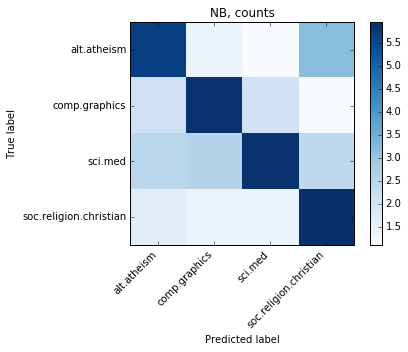

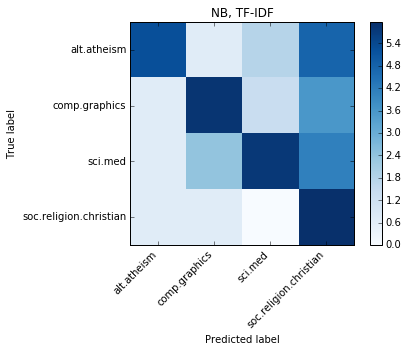

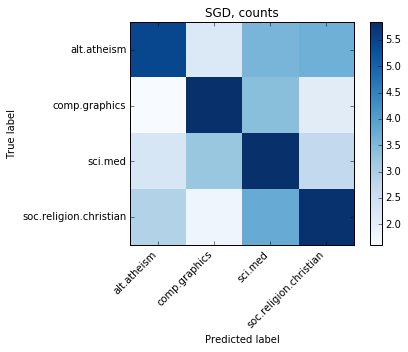

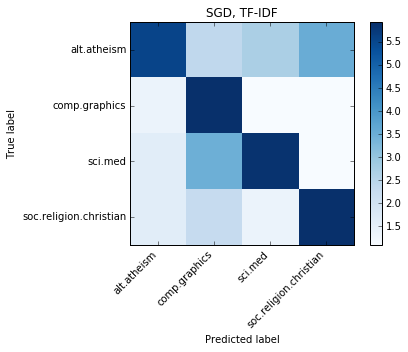

In [38]:
for name, pred in names_and_preds:
    cm = metrics.confusion_matrix(twenty_test.target, pred)
    plot_confusion_matrix(cm, logscale=True, labels=twenty_test.target_names, title=name)

## Parameter tuning using grid search

The `grid_search` module includes methods to sample a range of parameter space and to optimise the model.  The main class is `GridSearchCV` (CV = Cross Validation).  There are loads of useful parameters!  See the [docs](http://scikit-learn.org/stable/modules/generated/sklearn.grid_search.GridSearchCV.html).

To use `GridSearchCV`, first define a dictionary that maps from pipeline parameters to values.  The syntax is based on the (arbitrary) names given to the pipeline steps, plus the parameter name for the class used in that step, separate by a double underscore.  

In [70]:
from sklearn.grid_search import GridSearchCV

nb_count_params = {
        'vect__ngram_range': [(1, 1), (1, 2), (1, 3)],
        'clf__alpha': (1, 2, 3)
}

sgd_count_params = {
        'vect__ngram_range': [(1, 1), (1, 2), (1, 3)],
        'clf__alpha': (1e-2, 1e-3, 1e-4)
}

nb_tfidf_params = dict(nb_count_params)
nb_tfidf_params['vect__use_idf'] = (True, False)

sgd_tfidf_params = dict(sgd_count_params)
sgd_tfidf_params['vect__use_idf'] = (True, False)

The `GridSearchCV` instance wraps the `Pipeline` and reflects its behaviour.  Fit has to be called

In [67]:
data_size = len(twenty_train.data)

In [71]:
nb_count_grid = GridSearchCV(nb_count, nb_count_params, n_jobs=-1)
nb_count_grid = nb_count_grid.fit(twenty_train.data[:data_size], twenty_train.target[:data_size])

In [55]:
nb_tfidf_grid = GridSearchCV(nb_tfidf, nb_tfidf_params, n_jobs=-1)
nb_tfidf_grid = nb_tfidf_grid.fit(twenty_train.data[:data_size], twenty_train.target[:data_size])

KeyboardInterrupt: 

In [58]:
sgd_count_grid = GridSearchCV(sgd_count, sgd_count_params, n_jobs=-1)
sgd_count_grid = sgd_count_grid.fit(twenty_train.data[:data_size], twenty_train.target[:data_size])

In [57]:
sgd_tfidf_grid = GridSearchCV(sgd_tfidf, sgd_tfidf_params, n_jobs=-1)
sgd_tfidf_grid = sgd_tfidf_grid.fit(twenty_train.data[:data_size], twenty_train.target[:data_size])

KeyboardInterrupt: 

The `GridSearchCV` object can be used to predict, but more usefully it it can give the optimal parameter values.

In [72]:
nb_count_grid.grid_scores_

[mean: 0.97209, std: 0.00715, params: {'clf__alpha': 1, 'vect__ngram_range': (1, 1)},
 mean: 0.96544, std: 0.00213, params: {'clf__alpha': 1, 'vect__ngram_range': (1, 2)},
 mean: 0.96721, std: 0.00448, params: {'clf__alpha': 1, 'vect__ngram_range': (1, 3)},
 mean: 0.96012, std: 0.00388, params: {'clf__alpha': 2, 'vect__ngram_range': (1, 1)},
 mean: 0.94550, std: 0.00959, params: {'clf__alpha': 2, 'vect__ngram_range': (1, 2)},
 mean: 0.94417, std: 0.00598, params: {'clf__alpha': 2, 'vect__ngram_range': (1, 3)},
 mean: 0.94683, std: 0.00599, params: {'clf__alpha': 3, 'vect__ngram_range': (1, 1)},
 mean: 0.92424, std: 0.01135, params: {'clf__alpha': 3, 'vect__ngram_range': (1, 2)},
 mean: 0.93132, std: 0.01185, params: {'clf__alpha': 3, 'vect__ngram_range': (1, 3)}]

A couple of weird things here: 

 - the best score is obtained from the default parameters.  Adding extra ngram features actually reduces the performance
 - 

In [1]:
best_params, score, _ = max(nb_count_grid.grid_scores_, key=lambda x: x[1])
for param_name in best_params.items():
    print("{}: {}".format(param_name, best_params[param_name]))

NameError: name 'nb_count_grid' is not defined

In [83]:
nb_count_grid.grid_scores_[0][:]

({'clf__alpha': 1, 'vect__ngram_range': (1, 1)},
 0.97208684093929998,
 array([ 0.9814077 ,  0.97078353,  0.96404794]))

In [59]:
sgd_count_grid.grid_scores_

[mean: 0.92158, std: 0.00956, params: {'clf__alpha': 0.01, 'vect__ngram_range': (1, 1)},
 mean: 0.93310, std: 0.00164, params: {'clf__alpha': 0.01, 'vect__ngram_range': (1, 2)},
 mean: 0.91848, std: 0.01159, params: {'clf__alpha': 0.01, 'vect__ngram_range': (1, 3)},
 mean: 0.91537, std: 0.00796, params: {'clf__alpha': 0.001, 'vect__ngram_range': (1, 1)},
 mean: 0.92645, std: 0.00282, params: {'clf__alpha': 0.001, 'vect__ngram_range': (1, 2)},
 mean: 0.92202, std: 0.00407, params: {'clf__alpha': 0.001, 'vect__ngram_range': (1, 3)},
 mean: 0.92246, std: 0.00359, params: {'clf__alpha': 0.0001, 'vect__ngram_range': (1, 1)},
 mean: 0.92556, std: 0.00660, params: {'clf__alpha': 0.0001, 'vect__ngram_range': (1, 2)},
 mean: 0.93487, std: 0.00482, params: {'clf__alpha': 0.0001, 'vect__ngram_range': (1, 3)}]